In [1]:
#######################################################################################################
#Import Modules
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import calendar
from datetime import timedelta

In [3]:
#######################################################################################################
#Extract S&P500 Index Top200 Stickers
tickers = pd.read_csv('SP500_Holdings.csv')
tickers = tickers['Symbol'].iloc[:200].values.tolist()

In [4]:
#######################################################################################################
#Import data from yahoo finance API
start = '2019-01-07'
end = '2022-07-31'
num_of_stocks = 5

In [5]:
#######################################################################################################
#Import data from yahoo finance API
df = yf.download(tickers, start = start, end = end)
prices = df['Adj Close']

[*********************100%***********************]  200 of 200 completed


In [6]:
#######################################################################################################
#Calculate the winners in each month
daily_return = np.log(prices/prices.shift(1))
monthly_return = daily_return.resample('M').agg(lambda x: x.sum())
winners_index = monthly_return.apply(lambda s, n: s.nlargest(n).index, axis= 1, n = num_of_stocks)

In [7]:
#######################################################################################################
#Buy the winners (each in equal proportions) at the end of this month and hold them for one month
strategy = pd.DataFrame()

for i in range(len(winners_index) - 1):
    winners = winners_index[i].values.tolist()
    monthend = pd.to_datetime(monthly_return.index[i+1], format = '%Y-%m-%d')
    daysInMonth= int(calendar.monthrange(monthend.year, monthend.month)[1])
    winners_return = daily_return.loc[monthend-timedelta(days = daysInMonth-1):monthend, monthly_return.columns.isin(winners)]
    winners_return['mean return'] = winners_return.mean(axis = 1)
    strategy = strategy.append(winners_return)

strategy = strategy['mean return']

In [8]:
#######################################################################################################
#Assign S&P500 Index as our benchmark
sp500 = yf.download('SPY', start = start, end = end)
sp500['returns'] = np.log(sp500['Adj Close']/sp500['Adj Close'].shift(1))


[*********************100%***********************]  1 of 1 completed


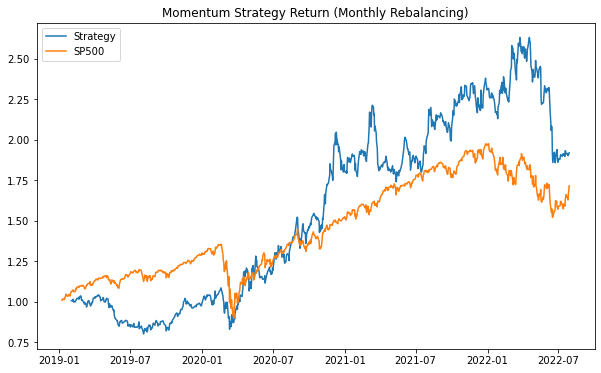

In [9]:
#######################################################################################################
#Plot the returns driven by the Strategy and the S&P500 Index
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Momentum Strategy Return (Monthly Rebalancing)')
ax.plot(strategy.cumsum().apply(np.exp), label = 'Strategy')
ax.plot(sp500['returns'].cumsum().apply(np.exp), label = 'SP500')
ax.legend()